# Unsupervised clustering for identifying spatial inhomogeneity on local electronic structures
Hideaki Iwasawa, Tetsuro Ueno, Takahiko Masui, Setsuko Tajima

Correspondence should be addressed to H.I. (iwasawa.hideaki@qst.go.jp)

# Part 3-1: Fuzzy-c-means clustering

- Module Setting


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skfuzzy.cluster import cmeans
import time

- Load iEDCs or iADCs, if you prepared in "Part 1" in advance
- Select and run only one of two (target map will be updated by the last run)

In [2]:
%store -r xw
%store -r yw
%store -r xn
%store -r yn
%store -r pn
%store -r xpos
%store -r ypos

In [3]:
%store -r iEDCs
%store -r eng
targetMap = iEDCs
slice_axis = eng
slice_dir = 'iEDC'
xaxislabel = 'Binding energy (eV)'
sn = np.shape(eng)[0]

In [4]:
%store -r iADCs
%store -r ang
targetMap = iADCs
slice_axis = ang
slice_dir = 'iADC'
xaxislabel = 'Detector angle (deg)'
sn = np.shape(ang)[0]

## (3-1-i) FCM clustering

- Preset number of clusters (n<sub>k</sub>) and fuzzifier (m)

In [4]:
nk = 3
m = 1.5

In [5]:
t1 = time.time() 

cntr, u, u0, d, jm, p, fpc = cmeans(targetMap.T, nk, m, 0.003, 10000, seed = 10)

t2 = time.time()
elapsed_time = t2-t1
print('Elapsed Time: ', elapsed_time)

Elapsed Time:  0.21941423416137695


## (3-1-ii) Probability Density

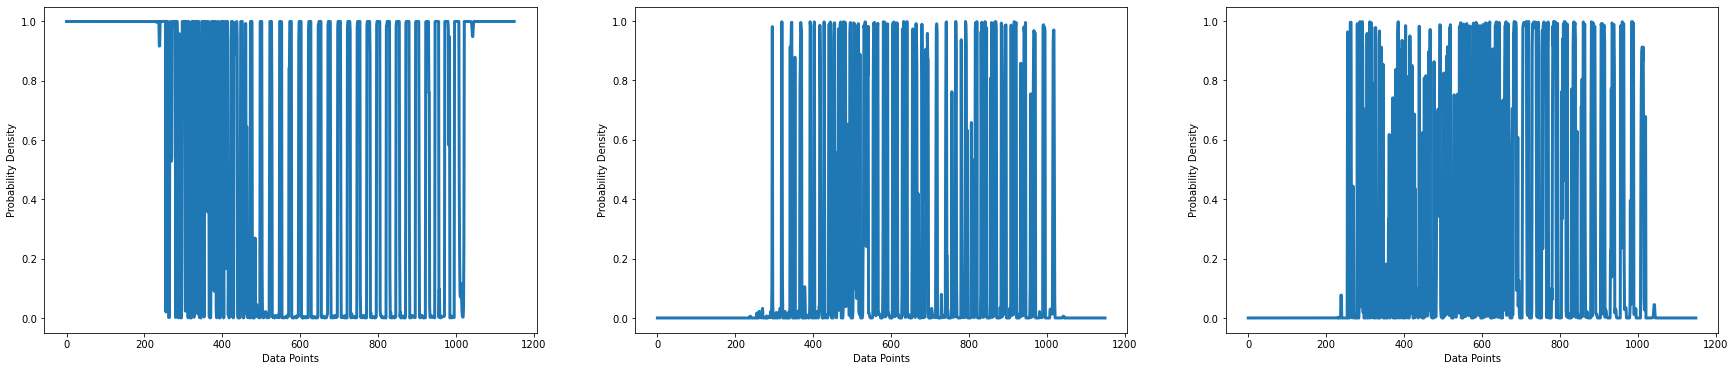

Elapsed Time:  0.2603003978729248


In [6]:
t1 = time.time() 

fig = plt.figure(figsize=(10*nk,6)) # for nk subplots

for i in range(nk):
    curprob = u[i]
    curax = fig.add_subplot(1, nk, i+1, xlabel='Data Points', ylabel='Probability Density')
    curax.plot(curprob, linewidth=3)
plt.show()

t2 = time.time()
elapsed_time = t2-t1
print('Elapsed Time: ', elapsed_time)

## (3-1-iii) Spatial Distribution of clusters (Z score)

- Main Body & Plotting

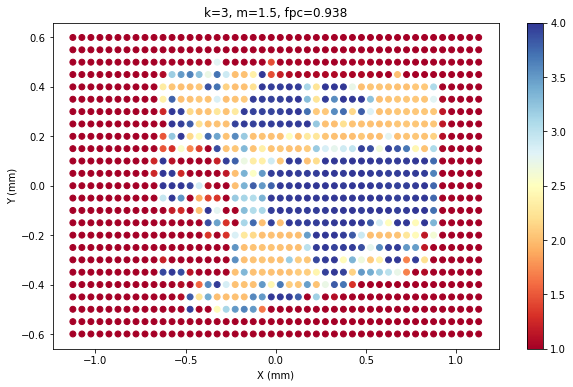

Elapsed Time:  0.17258143424987793


In [7]:
t1 = time.time() 

z = np.zeros(pn)
for i in range(pn):
    for j in range(nk):
        z[i] += u[j][i] * 2 ** (j)

zmin = 1
zmax = np.amax(z).round()
z2d = z.reshape(xn, yn) # For output as 2D image

fig = plt.figure(figsize=(10,6))
cm = plt.cm.get_cmap('RdYlBu')
ax = fig.add_subplot(1, 1, 1, xlabel='X (mm)', ylabel='Y (mm)')
mappable = ax.scatter(xpos, ypos, c=z, vmin=zmin, vmax=zmax, s=35, cmap=cm)        
fig.colorbar(mappable)
plt.title('k='+str(nk)+', m='+str(m)+', fpc='+str(format(fpc,'.3f'))) 
plt.show()

t2 = time.time()
elapsed_time = t2-t1
print('Elapsed Time: ', elapsed_time)

## (3-1-iv) Histogram : Probability density distribution

- Main Body & Plotting

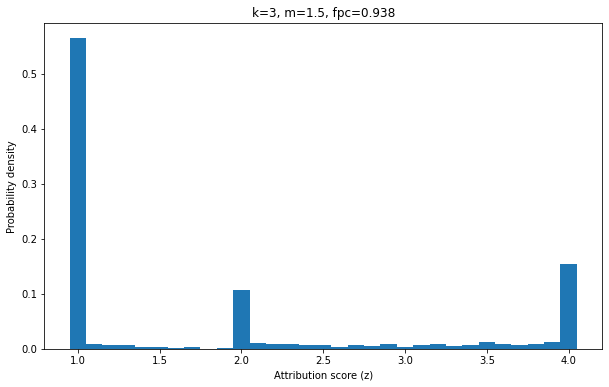

Elapsed Time:  0.1257317066192627


In [8]:
t1 = time.time() 

dbin = 0.1
bn = int((zmax-zmin)/dbin)+1

z_hist, z_bins = np.histogram(z, bins=bn)
z_hist = z_hist / np.sum(z_hist)
z_xhist = []
for i in range(bn):
    z_xhist.append(zmin+i*dbin)
    
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1, 1, 1, xlabel='Attribution score (z)', ylabel='Probability density')
ax.bar(z_xhist, z_hist, align='center', width=dbin)
ax.set_title('k='+str(nk)+', m='+str(m)+', fpc='+str(format(fpc,'.3f')))
plt.show()

t2 = time.time()
elapsed_time = t2-t1
print('Elapsed Time: ', elapsed_time)

## (3-1-v) Integrated EDC/ADC within each cluster, limited by probability range

- Level Setting

In [9]:
# Four levels
# 0.80-0.85, 0.85-0.90, 0.90-0.95, 0.95-1.00
levlist = [0.825, 0.875, 0.925, 0.975] # Center level
levwid = 0.05

- Main Body & Plotting

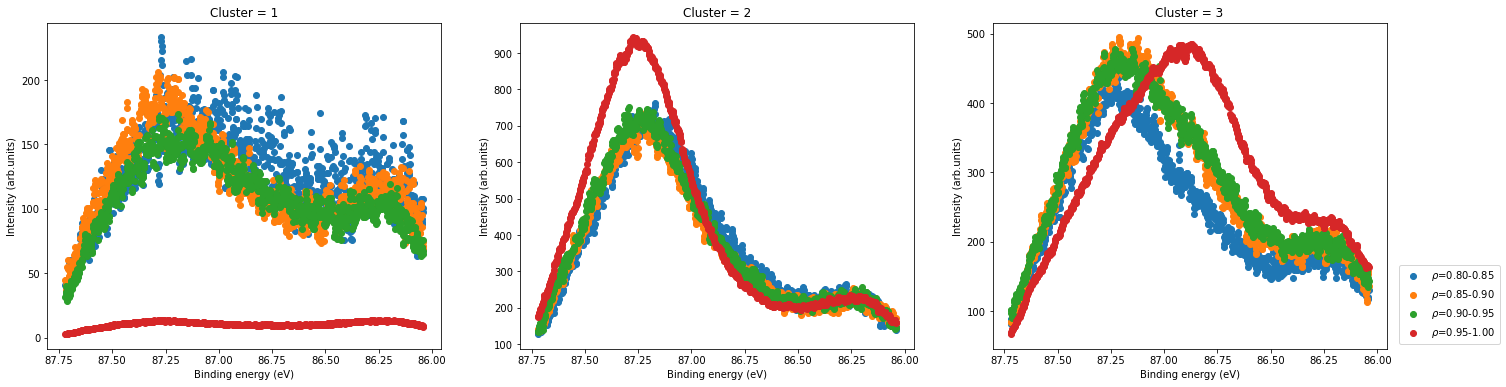

Elapsed Time:  0.5246016979217529


In [10]:
t1 = time.time() 

axes = []
fig = plt.figure(figsize=(8*nk,6))

ln = len(levlist)
intSlices = np.zeros((nk*ln, sn))

k = 0
for i in range(nk):
    axes.append(fig.add_subplot(1, nk, i+1, xlabel=xaxislabel, ylabel='Intensity (arb.units)'))
    axes[i].invert_xaxis()
    for k in range(len(levlist)):
        curslice = np.zeros(sn) # 1D y wave
        mn = 0 # Count Number of cluster member
        curlev = levlist[k]
        for j in range(pn):
            curpd = u[i][j]
            if curpd >= curlev - levwid/2 and curpd <= curlev + levwid/2:
                curslice += targetMap[j]
                mn += 1
            if j == pn-1:
                curslice /= mn
                curslice[0] = np.nan; curslice[sn-1] = np.nan # First and Last data point is replaced by NaN because of artifactual rapid intesity drop reflecting both edges of the detector
                intSlices[i*ln+k][:] = curslice # for saving
                plt.scatter(slice_axis, curslice, marker="o", label=r'$\rho$='+str(format(levlist[k]-levwid/2, '.2f'))+"-"+str(format(levlist[k]+levwid/2, '.2f')))
                plt.title('Cluster = '+str(i+1)) 
                if i == nk-1:     
                    plt.legend(bbox_to_anchor=(1.02, 0.0), loc='lower left')            
plt.show()

t2 = time.time()
elapsed_time = t2-t1
print('Elapsed Time: ', elapsed_time)

## (3-1-vi) Contour plot of probability density

- Plot settings

In [11]:
cmaps = ['Reds', 'Wistia', 'Blues', 'Greens', 'Purples', 'Greys', 'Oranges', 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu', 'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']
contlevs = [0.6, 0.7, 0.8, 0.9, 1.0] 

- Main Body & Plotting

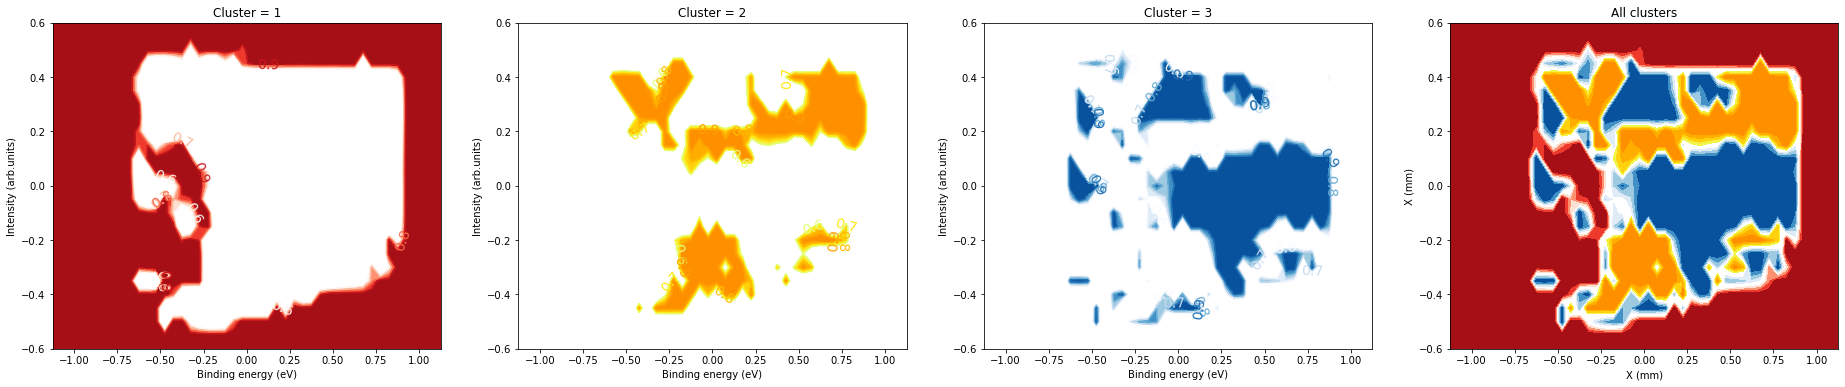

Elapsed Time:  0.5326452255249023


In [12]:
t1 = time.time() 

fig = plt.figure(figsize=(8*(nk+1),6)) 
ax = fig.add_subplot(1, nk+1, nk+1, xlabel='X (mm)', ylabel='X (mm)')
ax.set_title("All clusters")

x1d = np.linspace(-xw/2, xw/2, xn)
y1d = np.linspace(-yw/2, yw/2, yn)
Xgrid, Ygrid = np.meshgrid(y1d,x1d)

for i in range(nk):
    z1d = u[i]
    z2d = z1d.reshape(xn, yn)
    clev = np.round(np.max(z1d), decimals=1)
    axes.append(fig.add_subplot(1, nk+1, i+1, xlabel=xaxislabel, ylabel='Intensity (arb.units)'))
    cont1 = plt.contourf(Ygrid, Xgrid, z2d, cmap=cmaps[i], levels=contlevs)
    cont2 = plt.contour(Ygrid, Xgrid, z2d, cmap=cmaps[i], levels=contlevs)
    cont2.clabel(fmt='%1.1f', fontsize=14)
    plt.title('Cluster = '+str(i+1)) 
    ax.contourf(Ygrid, Xgrid, z2d, cmap=cmaps[i], levels=contlevs)
plt.show()

t2 = time.time()
elapsed_time = t2-t1
print('Elapsed Time: ', elapsed_time)

# (3-1-vii) Integrated ARPES image within each cluster

In [13]:
from nexusformat.nexus import *
import math
%store -r path2file
%store -r en
%store -r an
%store -r xn
%store -r yn
%store -r eng
%store -r ang

alldata = nxload(path2file) # All data including metadata
mapdata = alldata.entry1.instrument.analyser.data # Spatial Mapping Data (4D)

eng_ini = eng[0]
eng_end = eng[en-1]
ang_ini = ang[0]
ang_end = ang[an-1]

In [14]:
# threshold of probability density
prob_th1 = 0.95
prob_th2 = 1.00

- Main Body

In [15]:
t1 = time.time()

iARPESs = np.zeros((nk, an, en))

for i in range(nk):
    for j in range(pn):
        curpd = u[i][j]
        if curpd >= prob_th1 and curpd <= prob_th2:
            iARPESs[i][:][:] += mapdata[math.floor(j/yn)][j % yn][:][:].nxvalue

t2 = time.time()
elapsed_time = t2-t1
print('Elapsed Time: ', elapsed_time)

Elapsed Time:  150.34573984146118


- Plotting

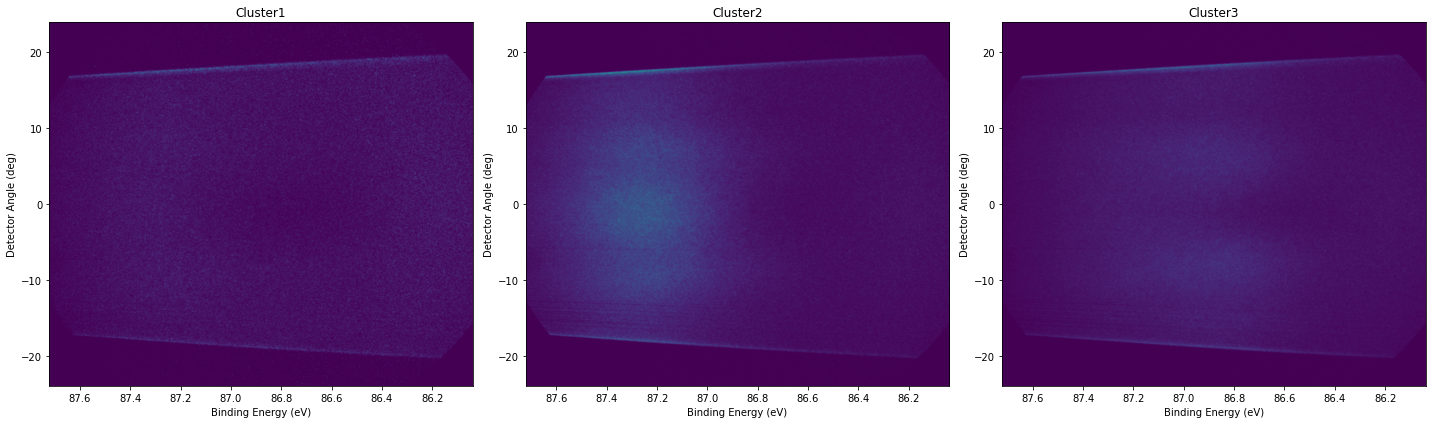

In [16]:
fig = plt.figure(figsize=(20,6))

for i in range(nk):
    iARPES = np.zeros((an, en))
    iARPES = iARPESs[i]
    axes.append(fig.add_subplot(1, nk, i+1, ylabel='Detector Angle (deg)', xlabel='Binding Energy (eV)'))
    axes[-1].set_title("Cluster"+str(i+1))
    plt.imshow(iARPES, aspect="auto", extent= [eng_ini, eng_end, ang_ini, ang_end])
fig.tight_layout()
plt.show()

# (3-1-viii) Fuzzifier dependence

#### **Histogram**

- Preset number of clusters (n<sub>k</sub>) and range of fuzzifier (m)
- They are adjustable parameters freely

In [17]:
nk = 3
ms = np.array([1.1, 1.3, 1.5, 1.8])

- Main body and plotting

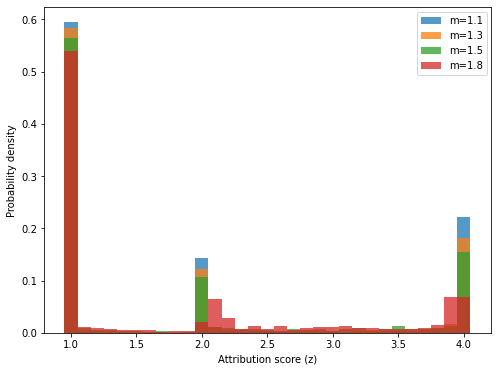

Elapsed Time:  1.1628892421722412


In [18]:
mn = np.size(ms)

t1 = time.time() 
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1, 1, 1, xlabel='Attribution score (z)', ylabel='Probability density')

for ii in range(mn):
    m = ms[ii]
    cntr, u, u0, d, jm, p, fpc = cmeans(targetMap.T, nk, m, 0.003, 10000, seed = 10)

    z = np.zeros(pn)
    for i in range(pn):
        for j in range(nk):
            z[i] += u[j][i] * 2 ** (j)

    zmin = 1
    zmax = np.amax(z).round()

    dbin = 0.1
    bn = int((zmax-zmin)/dbin)+1

    z_hist, z_bins = np.histogram(z, bins=bn)
    z_hist = z_hist / np.sum(z_hist)
    z_xhist = []
    for i in range(bn):
        z_xhist.append(zmin+i*dbin)

    ax.bar(z_xhist, z_hist, align='center', width=dbin, alpha=0.75, label = 'm='+str(m))
    
ax.legend(bbox_to_anchor=(0.825, 1.0), loc='upper left')
plt.show()

t2 = time.time()
elapsed_time = t2-t1
print('Elapsed Time: ', elapsed_time)

#### **Contour plot**

- For visualization, number of clusters (n<sub>k</sub>) and range of fuzzifier (m) are assumed to be 3 and m = 1.1, & 1.5
- Contour plot just display one level per each set of n<sub>k</sub> and m

In [19]:
nk = 3
ms = np.array([1.1, 1.8])
cmaps = ['Reds', 'Wistia', 'Blues','gist_heat', 'Oranges', 'ocean']
# if you change nk and ms (range of m), you have to modify cmaps
# Size of cmaps should be (nk * mn) : mn = size of ms
# (def) nk = 3, mn = 2 -> size of cmaps = 6

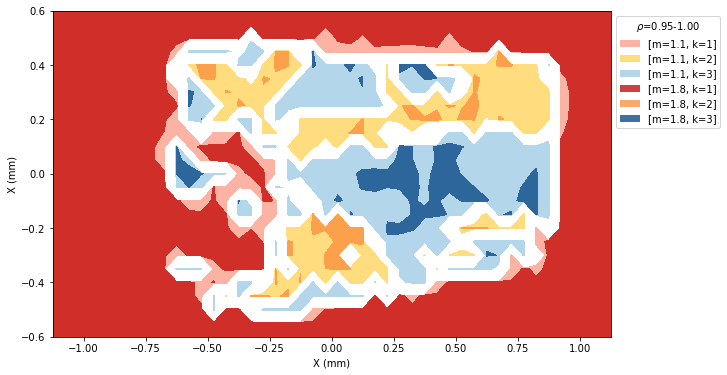

Elapsed Time:  0.5948855876922607


In [20]:
mn = np.size(ms)
contlevs = [0.95, 1.00]

t1 = time.time() 
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1, 1, 1, xlabel='X (mm)', ylabel='X (mm)')

x1d = np.linspace(-xw/2, xw/2, xn)
y1d = np.linspace(-yw/2, yw/2, yn)
Xgrid, Ygrid = np.meshgrid(y1d,x1d)
proxy = []
leglabels = []

l = 0
for i in range(mn):
    m = ms[i]
    cntr, u, u0, d, jm, p, fpc = cmeans(targetMap.T, nk, m, 0.003, 10000, seed = 10)

    z = np.zeros(pn)
    for j in range(pn):
        for k in range(nk):
            z[j] += u[k][j] * 2 ** (k)
    
    for j in range(nk):
        z1d = u[j]
        z2d = z1d.reshape(xn, yn)
        clev = np.round(np.max(z1d), decimals=1)
        cont = ax.contourf(Ygrid, Xgrid, z2d, cmap=cmaps[l], levels=contlevs, alpha=0.5+0.25*i)
        proxy += [plt.Rectangle((0,0),1,1, fc = pc.get_facecolor()[0]) for pc in cont.collections]
        legstr = '[m='+str(m)+', k='+str(j+1)+']'
        leglabels.append(legstr)
        l += 1
        
plt.legend(proxy, leglabels, bbox_to_anchor=(1.0, 1.0), loc='upper left', title = r'$\rho$=0.95-1.00')
plt.show()

t2 = time.time()
elapsed_time = t2-t1
print('Elapsed Time: ', elapsed_time)

# (3-1-ix) Output

- Save Directory

In [21]:
# default is to create "out" folder in the current directory, if not exist
import os
savedir = './out/'
if os.path.isdir(savedir) == False:
    os.mkdir(savedir)

- Probability Density

In [22]:
for i in range(nk):
    curprob = u[i]
    np.savetxt(savedir+'fcm_u_k'+str(i+1)+'nk'+str(nk)+'m'+str(m)+'.txt', curprob, delimiter='\r\n')

- Spatial Distribution of clusters (Z score), which can also be used for contour plot

In [23]:
np.savetxt(savedir+'fcm_z2d_nk'+str(nk)+'m'+str(m)+'.txt', z2d, delimiter='\t') # 2D wave - Z score
# Caution : Scales will not be stored in the wave

- Histogram

In [24]:
np.savetxt(savedir+'fcm_z_hist_nk'+str(nk)+'m'+str(m)+'.txt', z_hist, delimiter='\r\n')
np.savetxt(savedir+'fcm_z_xhist_nk'+str(nk)+'m'+str(m)+'.txt', z_xhist, delimiter='\r\n')

- Integrated EDC/ADC within each cluster

In [25]:
curslice = np.zeros(sn)
for i in range(nk):
    for k in range(ln):
        curslice = intSlices[i*ln+k][:]
        curlevel = str(format(levlist[k]-levwid/2, '.2f'))+"-"+str(format(levlist[k]+levwid/2, '.2f'))
        np.savetxt(savedir+'fcm_'+slice_dir+'_k'+str(i+1)+'nk'+str(nk)+'m'+str(m)+'_'+curlevel+'.txt', curslice, delimiter='\r\n')
        np.savetxt(savedir+'fcm_x'+slice_dir+'_k'+str(i+1)+'nk'+str(nk)+'m'+str(m)+'_'+curlevel+'.txt', slice_axis, delimiter='\r\n')

- Integrated ARPES image within each cluster

In [26]:
for i in range(nk):
    iARPES = iARPESs[i][:][:]
    np.savetxt(savedir+'fcm_iARPES_k'+str(i+1)+'nk'+str(nk)+'m'+str(m)+'.txt', iARPES, delimiter='\t')